# Use Encoding to Improve K-means on the MNIST Dataset

In [2]:
n_rows = n_cols = 28
n_clusters = 10

## Visualize Results & Calculate a Purity Score
Display a sorted confusion matrix to identify if the correct number was clustered most of the time
This will be used in the baseline and with encoding

In [3]:
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

def print_results(c, y):
    y_train_to_clustered  = np.dstack([y, c])[0]
    clustered_tallies = np.zeros((n_clusters, n_clusters), dtype=int)
    for i in range(0, len(y_train_to_clustered)):
        clustered_tallies[y_train_to_clustered[i][1]][y_train_to_clustered[i][0]] += 1

    cluster_to_num_map = list(map(lambda x: np.argmax(x), clustered_tallies))
    clustered_tallies = sorted(clustered_tallies, key=lambda e: np.argmax(e)) 

    fig, ax = plt.subplots(1, figsize=(15,15))
    p = sn.heatmap(clustered_tallies, annot=True, fmt="d", annot_kws={"size": 10}, cmap='coolwarm', ax=ax, square=True, yticklabels=cluster_to_num_map)
    plt.xlabel('Actual', fontsize=18)
    plt.ylabel('Cluster', fontsize=18)
    p.tick_params(length=0)
    p.xaxis.tick_top()
    p.xaxis.set_label_position('top')
    plt.title('Cluster match count for each number', fontsize= 30)
        
    # purity - sum of correct in each class divided by the total number of images
    purity_sums = np.zeros((10, 1))

    for i in range(0, len(y_train_to_clustered[:])):
        if cluster_to_num_map[y_train_to_clustered[i][1]] == y[i]:
            purity_sums[cluster_to_num_map[y_train_to_clustered[i][0]]] += 1
    
    print('Purity ', np.add.reduce(purity_sums)[0] / len(y))
    

## Generate a K-Means Baseline

Purity  0.59085


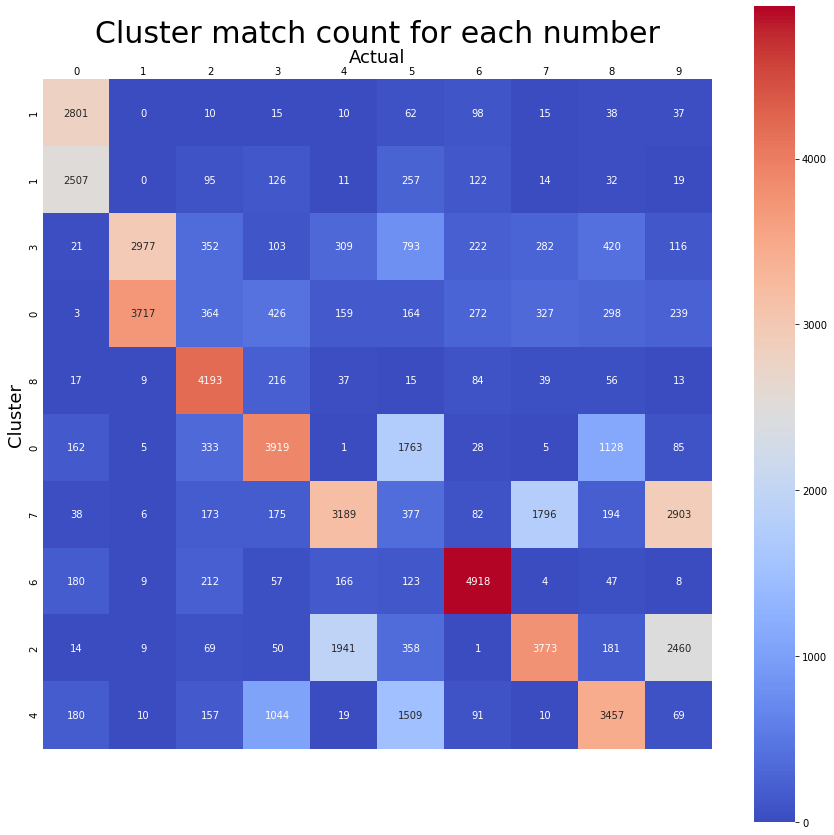

In [4]:
from keras.datasets import mnist
from sklearn.cluster import KMeans

(x_org, y_train), (x_test_org, y_test) = mnist.load_data()
x_train = x_org.reshape((x_org.shape[0], -1))
x_test = x_test_org.reshape(x_test_org.shape[0], n_rows, n_cols, 1)
input_shape = (n_rows, n_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

k_base = KMeans(n_clusters=n_clusters)
k_base.fit(x_train)
base_clustered = k_base.predict(x_train)
print_results(base_clustered, y_train)

## Create Auto Encoder
Use Keras to create an image autoencoder consisting of an encoder and decoder
The autoencoder takes an image, reduces it to n dimensions and recreates it

In [5]:
import keras
from keras import Model
from keras.datasets import mnist
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape, BatchNormalization
from keras import activations
from keras.layers.advanced_activations import LeakyReLU
import numpy as np

n_dims = 14 # the more dimensions the more information is retained

def get_encoder(x):
    x = Conv2D(16, (3, 3), activation=activations.relu, padding='same', name='conv2d16')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(784, activation=activations.relu, name='dense1')(x)
    x = Dense(392, activation=activations.relu, name='dense2')(x)
    x = Dense(196, activation=activations.relu, name='dense3')(x)
    x = Dense(n_dims, activation=activations.relu, name='denseDim')(x)
    return x

def get_decoder(x):
    x = Dense(196, activation=activations.relu)(x)
    x = Dense(392, activation=activations.relu)(x)
    x = Dense(784, activation='sigmoid')(x)
    x = Reshape((28,28,1))(x)
    return x

x = Input(shape=(n_rows, n_cols, 1), name='input')

encoder = get_encoder(x)
decoder = get_decoder(encoder)
autoencoder = Model(x, decoder)

autoencoder.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

autoencoder.summary()

(x_org, y_train), (x_test_org, y_test) = mnist.load_data()
x_train = x_org.reshape(x_org.shape[0], n_rows, n_cols, 1)
x_test = x_test_org.reshape(x_test_org.shape[0], n_rows, n_cols, 1)
input_shape = (n_rows, n_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d16 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense1 (Dense)               (None, 784)               9835280   
_________________________________________________________________
dense2 (Dense)               (None, 392)               307720    
_________________________________________________________________
dense3 (Dense)               (None, 196)               77028     
_________________________________________________________________
denseDim (Dense)             (None, 14)                2758      
__________

In [6]:
# Train Model

In [ ]:
cbs = [keras.callbacks.EarlyStopping(patience=15, monitor='val_loss'), 
       keras.callbacks.ModelCheckpoint(filepath='auto_encoder_weights.h5',
       save_best_only=True)]

training_results = autoencoder.fit(x_train, x_train,
          batch_size=100,
          epochs=300,
          verbose=1,
          validation_data=(x_test, x_test),
          callbacks=cbs)
print('complete')

## View Reconstructed Images to Confirm Auto Encoder is Working

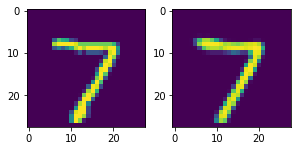

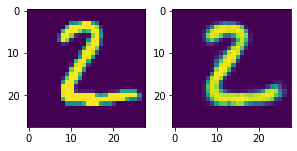

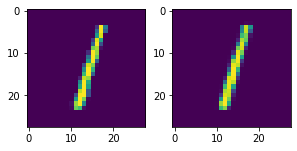

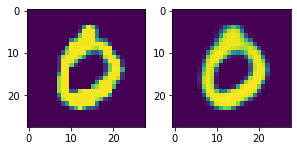

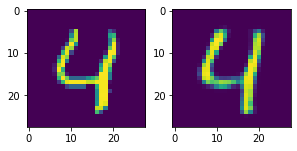

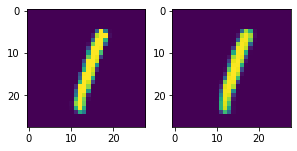

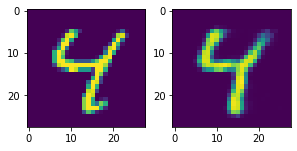

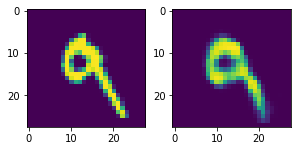

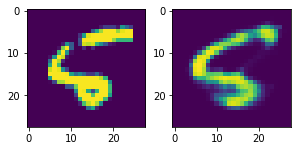

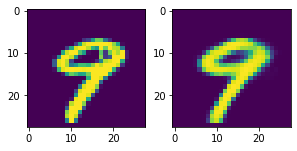

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

autoencoder.load_weights('auto_encoder_weights.h5')
n_images = 10
auto_encoded = autoencoder.predict(x_test[:n_images])
auto_encoded = (auto_encoded * 255).astype('int32')
auto_encoded = auto_encoded.reshape(auto_encoded.shape[0], n_rows, n_cols)

for i in range(0, n_images):
    fig=plt.figure(figsize=(10, 10))
    fig.add_subplot(4, 4, 1)
    imshow(x_test_org[i])
    fig.add_subplot(4, 4, 2)
    imshow(auto_encoded[i])

## Create Encoder

In [8]:
encoder = get_encoder(x)
encoder = Model(x, encoder)

encoder.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
# load the weightds created by the auto encoder
encoder.load_weights('auto_encoder_weights.h5', by_name=True)
encoder.summary()
encoded = encoder.predict(x_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d16 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense1 (Dense)               (None, 784)               9835280   
_________________________________________________________________
dense2 (Dense)               (None, 392)               307720    
_________________________________________________________________
dense3 (Dense)               (None, 196)               77028     
_________________________________________________________________
denseDim (Dense)             (None, 14)                2758      
Total para

## Plot Encoded Data
The chart will be reflect the data when n_dim = 3
To obtain accurate clustering more than 3 dimensions of information is needed

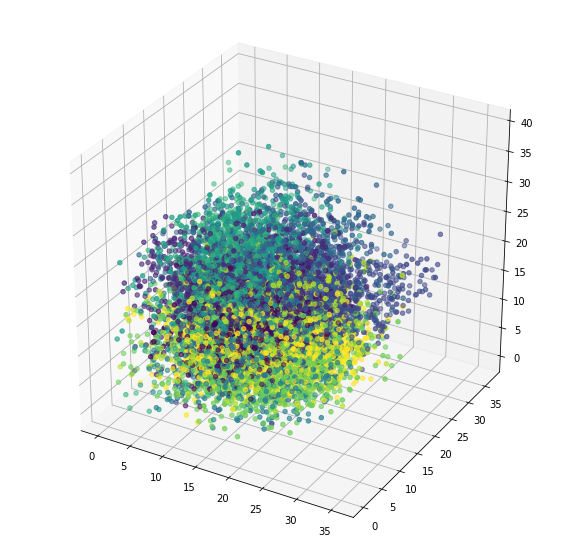

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = encoded[:,0]
y = encoded[:,1]
z = encoded[:,2]
ax = plt.axes(projection='3d')
# limit the amout of plotted data to make the chart easier to view
min = 32000
max = min+10000
ax.scatter(x[min:max], y[min:max], z[min:max], c=y_train[min:max], cmap='viridis')

## Train K-Means with Encoded Data

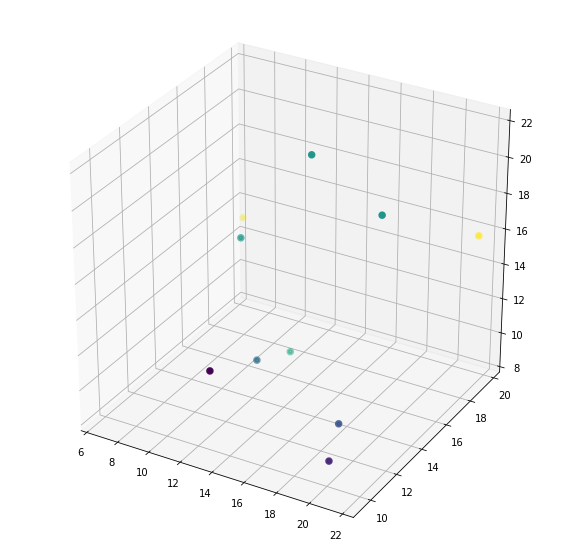

In [10]:
from sklearn.cluster import KMeans

k_encoded = KMeans(n_clusters=n_clusters)
k_encoded.fit(encoded)
centers = k_encoded.cluster_centers_

plt.figure(figsize=(10,10))

x = centers[:,0]
y = centers[:,1]
z = centers[:,2]

ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=y, cmap='viridis', linewidth=3);


## Find the Purity of K-Means Predictions
Use the distance of of training data to centers to match target labels to clusters

Purity  0.65535


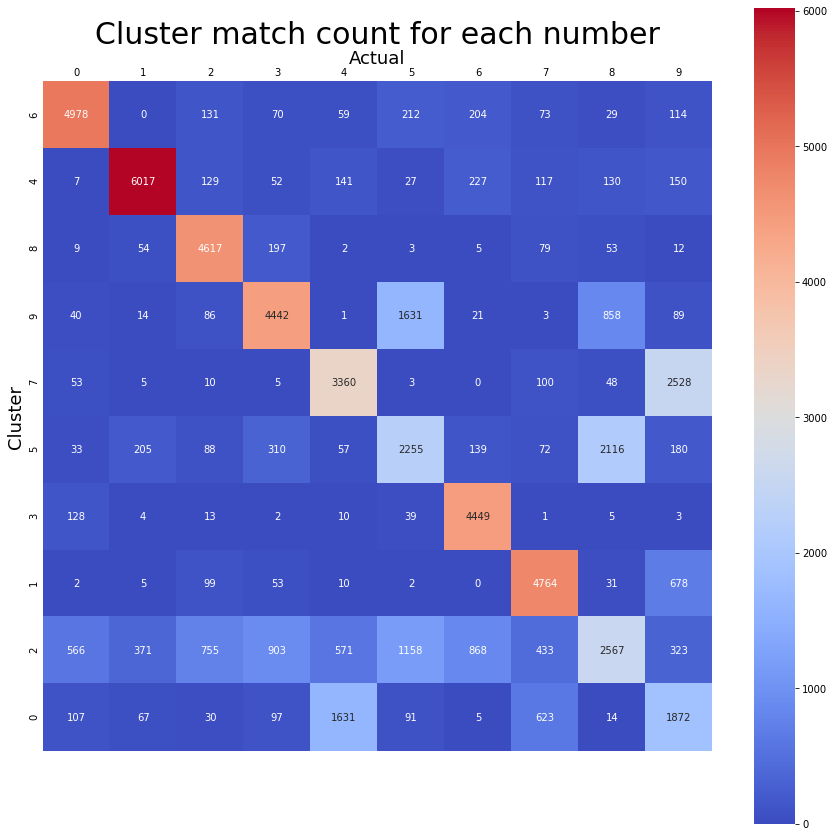

In [11]:
encoded_clustered = k_encoded.predict(encoded)
print_results(encoded_clustered, y_train)